
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [3]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

# Bibliotecas para preparação dos dados
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, precision_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, auc
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#### Sequência de passos para rodar e documentar evidências dos treinamentos:
1. Carregamento do dataset já pré-processado e balanceado;
2. Crie uma pasta com nome reports caso não tenha baixado o repositório: https://github.com/brugnaro2022/nlp;
3. Cada célula deve ser executada quando necessário;
4. Alterar variável TRAIN_NUM para o número do respectivo treinamento;
5. Alterar quando necessário alterar variável DATASET para o nome do respectivo dataset;
6. Alterar variável LEARNING_RATE;
7. Realizar análise estatística dos resultados do relatório;
8. Popular a planilha 'Testes Estatísticos - base' com resultados das análises do relatório;
9. Atualizar cores da planilha 'Testes Estatísticos - base';
10. No final de todos treinamentos da base, definir qual o melhor resultado e popular a planilha 'Testes Estatísticos - melhores resultados'
11. No final de todos os treinamentos de todas as bases e realização dos testes estatísticos, temos que responder as questões propostas.

In [4]:
TRAIN_NUM = '01'
MODEL = 'TFIDF+MLP'
DATASET = 'b2w'

In [5]:
# Importação do dataset buscape
df = pd.read_csv(f'../datasets/{DATASET}_preprocessed_balanced_cleared.csv')

In [6]:
batch_01 = df

In [7]:
INSTANCES = batch_01.shape[0]

In [8]:
# Verificando quantidade de ratings
batch_01['rating'].value_counts()

rating
0    33766
1    33766
Name: count, dtype: int64

In [9]:
# Definindo documents e labels
documents = batch_01['review_text'].tolist()
labels = np.array(batch_01['rating'])

In [10]:
# Gerando tfidf matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
TFIDF_MATRIX = tfidf_vectorizer.fit_transform(documents)

In [11]:
# Definindo quantidade de folds para cross validation
K_FOLDS = 10
KFOLD = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
FOLD_ACCURACIES = []
FOLD_F1_SCORES = []
FOLD_CLASSIFICATION_REPORTS = []

In [12]:
DROPOUT = 0.05
LEARNING_RATE = 5e-3
EPOCHS = 5
BATCH_SIZE = 32
LOSS = 'binary_crossentropy'
METRICS = ['acc']
CALLBACKS=[EarlyStopping('loss', patience=3)]
VERBOSE = 1

In [13]:
data = []
for fold, (train_idx, test_idx) in enumerate(KFOLD.split(TFIDF_MATRIX), start=1):
    # Separando datasets
    X_train, X_test = TFIDF_MATRIX[train_idx], TFIDF_MATRIX[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # Arquitetura MLP
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(DROPOUT)),
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilando o modelo
    LEARNING_RATE = LEARNING_RATE
    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    # Treinando o modelo
    model_history = model.fit(
        X_train.toarray(),
        y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE, 
        callbacks=CALLBACKS,
        validation_data=(X_test.toarray(), y_test)
    )
    
    # Avaliando o modelo
    predictions = (model.predict(X_test.toarray()) > 0.5).astype(int)
    
    FOLD_ACCURACY = accuracy_score(y_test, predictions)
    FOLD_ACCURACIES.append(FOLD_ACCURACY)
    
    FOLD_F1_SCORE = f1_score(y_test, predictions)
    FOLD_F1_SCORES.append(FOLD_F1_SCORE)
    
    FOLD_CLASSIFICATION_REPORT = classification_report(y_test, predictions)
    FOLD_CLASSIFICATION_REPORTS.append(FOLD_CLASSIFICATION_REPORT)
    
    print('-'*80)
    print(f'Resultado treinamento fold: {fold}')
    print('-'*80)
    print(f'Modelo: {MODEL}')
    print('-'*80)
    print(f'Dataset: {DATASET}')
    print('-'*80)
    print(f'Quantidade de Instâncias: {INSTANCES}')
    print('-'*80)
    print('Hiper-parâmetros:')
    print(f'Dropout = {DROPOUT}')
    print(f'Learning rate = {LEARNING_RATE}')
    print(f'Épocas = {EPOCHS}')
    print('-'*80)
    print(f'Cross-validation {K_FOLDS} folds:')
    print(f'Fold {fold} de 10 K-folds')
    print('-'*80)
    print('Métricas:')
    print(f"Acuracia teste = {FOLD_ACCURACY:.2f}")
    print(f"F1 Score teste = {FOLD_F1_SCORE:.2f}")
    print('-'*80)
    #print('Relatório mais detalhado:')
    #print(FOLD_CLASSIFICATION_REPORT)
    #print('-'*80)
    print(f'Final treinamento fold: {fold}')
    print('-'*80)
    
    data.append([TRAIN_NUM, MODEL, DATASET, INSTANCES, K_FOLDS, fold, DROPOUT, LEARNING_RATE, EPOCHS, f"{FOLD_ACCURACY:.2f}", f"{FOLD_F1_SCORE:.2f}"])
    columns = ['Numero_Treinamento', 'Modelo', 'Dataset', 'Instancias', 'K-folds_qtd', 'Fold', 'Dropout', 'Learning_rate', 'Epocas', 'Acuracia', 'F1_score']

print(f'Salvando relatório...')
report_data_df = pd.DataFrame(data, columns=columns)
csv_file_path = f'./reports/{MODEL}_{DATASET}_train_{TRAIN_NUM}.csv'
report_data_df.to_csv(csv_file_path, index=False)
print(f'Relatório salvo com sucesso!')

2023-08-14 13:43:34.645973: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11203573408 exceeds 10% of free system memory.


Epoch 1/5
 488/1900 [======>.......................] - ETA: 21s - loss: 0.2256 - acc: 0.9168

KeyboardInterrupt: 

In [40]:
# Calculando average accuracy
avg_accuracy = np.mean(FOLD_ACCURACIES)
print(f"Average Accuracy: {avg_accuracy:.2f}")

Average Accuracy: 0.86


In [39]:
NB_START_EPOCHS = 5

In [41]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

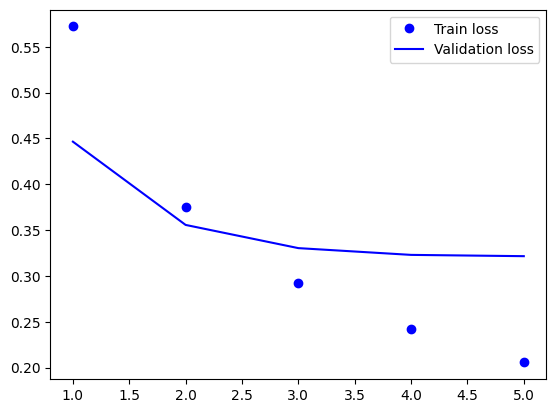

In [42]:
eval_metric(model_history, 'loss')

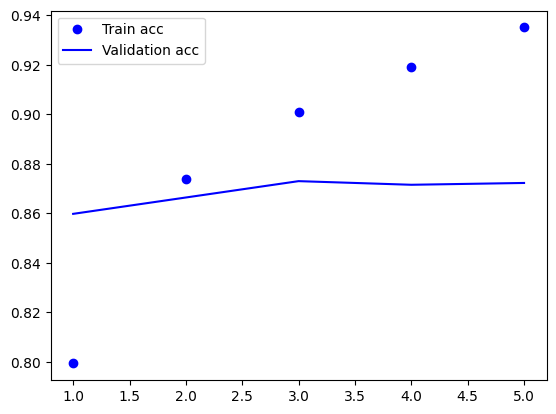

In [43]:
eval_metric(model_history, 'acc')

In [44]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

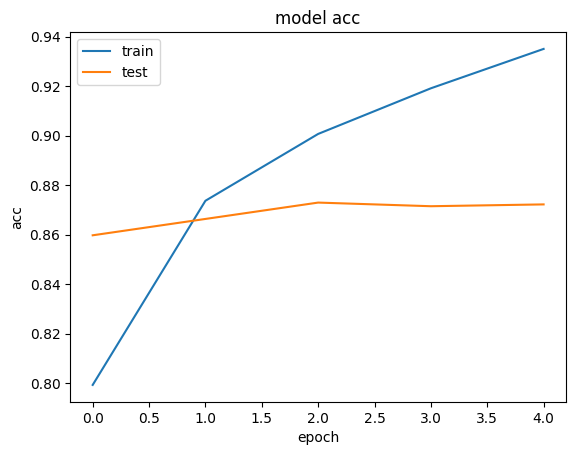

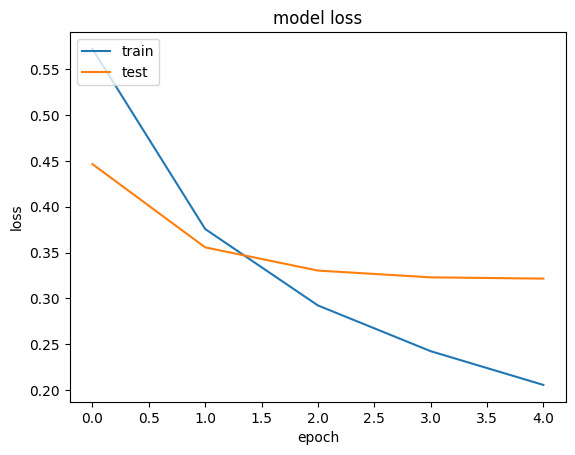

In [45]:
plot_eval_metrics(model_history, 'acc')
plot_eval_metrics(model_history, 'loss')